<a href="https://colab.research.google.com/github/DorAzaria/Voice-Emotion-Recognition/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Speach Emotion Recognition***

By Dolev Abuhazira and Dor Azaria.

In [1]:
from google.colab import drive
drive.mount('/content/data/')

Mounted at /content/data/


***Imports***

In [2]:
%%capture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
import os
import datetime
import torchaudio
import matplotlib.pyplot as plt
from numpy import mat
np.set_printoptions(suppress=True)

!sudo apt-get install libportaudio2
!sudo apt-get install python-scipy

!pip install sounddevice
!pip install scipy

import sounddevice
from scipy.io.wavfile import write

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = {0: 'positive', 1:'neutral', 2:'negative'}

### ***Preprocessed Data***
---

Data class contains the dataset (for each audio file: audio_path, features, label). ``dataset5.pth`` contains extracted features used by Wav2Vec pretrained model,  the audio files are from RAVDESS, TESS and URDU datasets. - for more details about the preprocess [click here](https://github.com/DorAzaria/Voice-Emotion-Recognition/blob/main/preprocess.ipynb).


We split ``self.data`` into random 80% train, 10% test and 10% valid subsets.

Each subset (train, test, valid) will be a ``TensorLoader`` type that represents a Python iterable over a dataset.

By using ``TensorLoader`` we can easily:
1. Activate an automatic batching method (Using ``batch_size=32``).
2. Drop the last incomplete batch, if the dataset size is not divisible by the batch size (Using ``drop_last=True``).
3. To have the data reshuffled at every epoch (Using ``shuffle=True``).

In [13]:
class Data:

    def __init__(self):
        file_handler = open('/content/data/MyDrive/dl/dataset5.pth', 'rb')
        self.data = pickle.load(file_handler)

        x_dataset = [embedding[1] for embedding in self.data]
        y_dataset = [label[2] for label in self.data]

        #[80% train, 10% valid, 10% test]
        train_x, rem_x, train_y, rem_y = train_test_split(np.array(x_dataset), np.array(y_dataset), train_size=0.80) 
        valid_x, test_x, valid_y, test_y = train_test_split(rem_x, rem_y, test_size=0.5)

        # Convert numpy to torch.Tensor type
        self.train_x = torch.from_numpy(train_x)
        self.train_y = torch.from_numpy(train_y)

        self.valid_x = torch.from_numpy(valid_x)
        self.valid_y = torch.from_numpy(valid_y)

        self.test_x = torch.from_numpy(test_x)
        self.test_y = torch.from_numpy(test_y)

        # Create a DataLoader for each subset (train, valid, test)
        torch_train = TensorDataset(self.train_x, self.train_y)
        torch_valid = TensorDataset(self.valid_x, self.valid_y)
        torch_test = TensorDataset(self.test_x, self.test_y)

        self.train_loader = DataLoader(torch_train, batch_size=32, drop_last=True, shuffle=True)
        self.valid_loader = DataLoader(torch_valid, batch_size=32, drop_last=True, shuffle=True)
        self.test_loader = DataLoader(torch_test, batch_size=32, drop_last=True, shuffle=False)

**Plot**

Prints the train loss vs. valid loss when an earlystopping occurs.

In [5]:
def plotEarlyStopping(train_loss, valid_loss):
  epochs_x_axis = np.linspace(1, len(train_loss), len(train_loss)).astype(int)
  plt.plot(epochs_x_axis, train_loss)
  plt.plot(epochs_x_axis, valid_loss)
  plt.title('Train VS Valid Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'], loc='upper left')
  plt.savefig("model_plot.png")

### ***ConvNet Class Model***
---

The ``ConvNet`` model is a convolutional neural network. The model subclass ``torch.nn.Module`` which is a base class for all neural network modules.
The model architecture using ``BatchNorm2d()``,  ``MaxPool2d()`` , ``ReLU()``and more methods from ``nn.Module``.

The input size of the network is (1, 149, 32).

In [6]:
DROP_OUT = 0.8
NUM_OF_CLASSES = 3

class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Hyper parameters
        self.epochs = 300
        self.batch_size = 32
        self.learning_rate = 0.0001

        # Model Architecture
        self.first_conv = nn.Conv2d(1, 96, kernel_size=(5, 5), padding=1) # (96, 147, 30)
        self.first_bn = nn.BatchNorm2d(96)
        self.first_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)) # (96, 73, 14)

        self.second_conv = nn.Conv2d(96, 256, kernel_size=(5, 5), padding=1) # (256, 71, 12)
        self.second_bn = nn.BatchNorm2d(256)
        self.second_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1)) # (256, 69, 10)

        self.third_conv = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1) # (384, 69, 10 )
        self.third_bn = nn.BatchNorm2d(384)

        self.forth_conv = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.forth_bn = nn.BatchNorm2d(256)

        self.fifth_conv = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.fifth_bn = nn.BatchNorm2d(256)
        self.fifth_polling = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)) # (256, 68, 9)

        self.sixth_conv = nn.Conv2d(256, 64, kernel_size=(2, 2), padding=1) # (64, 69, 10)

        self.seventh_conv = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1) # (64, 69, 10)
        self.seventh_polling = nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)) # (64, 34, 5)

        self.eighth_conv = nn.Conv2d(64, 32, kernel_size=(3,3), padding=1) # (32, 34, 5)
        self.first_drop = nn.Dropout(p=DROP_OUT)

        self.avg_polling = nn.AdaptiveAvgPool2d((1, 1))
        self.first_dense = nn.Linear(32, 1024)
        self.second_drop = nn.Dropout(p=DROP_OUT)

        self.second_dense = nn.Linear(1024, NUM_OF_CLASSES)

    def forward(self, X):
        x = nn.ReLU()(self.first_conv(X))
        x = self.first_bn(x)
        x = self.first_polling(x)

        x = nn.ReLU()(self.second_conv(x))
        x = self.second_bn(x)
        x = self.second_polling(x)

        x = nn.ReLU()(self.third_conv(x))
        x = self.third_bn(x)

        x = nn.ReLU()(self.forth_conv(x))
        x = self.forth_bn(x)

        x = nn.ReLU()(self.fifth_conv(x))
        x = self.fifth_bn(x)
        x = self.fifth_polling(x)

        x = nn.ReLU()(self.sixth_conv(x))

        x = nn.ReLU()(self.seventh_conv(x))
        x = self.seventh_polling(x)

        x = nn.ReLU()(self.eighth_conv(x))

        x = self.first_drop(x)
        x = self.avg_polling(x)

        x = x.view(-1, x.shape[1])  # output channel for flatten before entering the dense layer

        x = nn.ReLU()(self.first_dense(x))
        x = self.second_drop(x)

        x = self.second_dense(x)
        y = nn.LogSoftmax(dim=1)(x)  # consider using Log-Softmax

        return y

    def get_epochs(self):
        return self.epochs

    def get_learning_rate(self):
        return self.learning_rate

    def get_batch_size(self):
        return self.batch_size

# **TEST**
---

* ``torch.max()`` returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).

In [61]:
def test(convnet_model, dataset):

    example_class = [0] * len(dataset.test_y) 
    text_results = []
    
    with torch.no_grad():
        total_correct = 0
        example_index = 0
        label_correct = [0, 0 , 0]
        label_samples = [0, 0 , 0]
        
        for embedding, labels in dataset.test_loader:
            
            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
            embedding = embedding.to(device)
            labels = labels.to(device)
            
            outputs = convnet_model(embedding)
            _, predicted = torch.max(input= outputs, dim=1)

            total_correct += (predicted == labels).sum().item()

            for i in range(convnet_model.batch_size):
                label = labels[i]
                pred = predicted[i]

                if label == pred:
                    label_correct[label] += 1

                label_samples[label] += 1
                example_class[example_index] = pred.cpu()
                example_index += 1

        acc = 100.0 * total_correct / len(dataset.test_y)
        text_results.append(f'Accuracy of the network: {acc} %')

        for i in range(3):
            acc = 100.0 * label_correct[i] / label_samples[i]
            text_results.append(f'Accuracy of {classes[i]}: {acc} %')
        
        return example_class, text_results

# **Validation**

---



In [ ]:
def validation(convnet_model, dataset, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for embedding, labels in dataset.valid_loader:
            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            embedding = embedding.to(device)

            outputs = convnet_model(embedding)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(dataset.valid_loader)


# **Train**
---


In [65]:
def train_model(convnet_model, dataset):
    save_counter=0
    loss_vals_train = []
    loss_valid = []

    optimizer = torch.optim.Adam(convnet_model.parameters(), lr=convnet_model.learning_rate, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.99, 3.0, 1.0])).to(device) # [1184, 688, 2363] --> 4235 examples
    
    n_total_steps = len(dataset.train_loader)

    # Early stopping
    the_last_loss = 100
    patience = 0
    trigger_times = 0

    for epoch in range(convnet_model.get_epochs()):

        convnet_model.train()
        epoch_acc = []
        epoch_loss = []

        for i, (embedding, labels) in enumerate(dataset.train_loader):

            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
        
            labels = labels.to(device)
            embedding = embedding.to(device)

            # Forward pass
            outputs = convnet_model.forward(embedding)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            if i == 90:
                print(f'Epoch [{epoch + 1}/{convnet_model.epochs}], Loss: {loss.item():.4f}')
                
        loss_vals_train.append(sum(epoch_loss)/len(epoch_loss))

        _ , res , test_acc = test(convnet_model, dataset)

        #### EARLY STOPPING ~~~~~~~~~~~~~~~~~~~
        the_current_loss = validation(convnet_model, dataset, criterion)
        loss_valid.append(the_current_loss)
        print(res)
        if the_current_loss > loss_vals_train[-1]:
            trigger_times += 1
            print('trigger times:', trigger_times)
            # if loss_vals_train[-1] < 0.7:
            torch.save(cnn, f"/content/model{save_counter}.pth")
            plotEarlyStopping(loss_vals_train,loss_valid, f"/content/model{save_counter}.png")
            print(f'saved model{save_counter}.pth')
            save_counter += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

        else:
            trigger_times = 0

        the_last_loss = the_current_loss
        ##### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


    # plotEarlyStopping(loss_vals_train,loss_valid)

# **Main**

---


## NORM AND INFERENCE

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)


def inference(file_name):
    SAMPLE_RATE = 16000
    waveform, sample_rate = torchaudio.load(filepath=file_name,  num_frames=SAMPLE_RATE * 3)
    # waveform = waveform.view(1, 96000)
    waveform = waveform.to(device)
    
    if (len(waveform[0]) < 48000):
        print(f'less than 3 seconds: {file_name}')

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    with torch.inference_mode():
        embedding, _ = model(waveform)

    return embedding.unsqueeze(0)


def Norm(X):
    embedding = X.detach().cpu().numpy()
    for i in range(len(embedding)):
        mlist = embedding[0][i]
        embedding[0][i] = 2 * (mlist - np.max(mlist)) / (np.max(mlist) - np.min(mlist)) + 1

    return torch.from_numpy(embedding).to(device)

## START TRAIN

---



In [ ]:
dataset = Data()
cnn = ConvNet()
cnn.to(device)
train_model(cnn, dataset)

In [ ]:
print(dataset.distrib)
print(dataset.weights)

[822, 489, 1653]
[2.010948905109489, 3.3803680981595092, 1.0]


In [ ]:
torch.save(cnn, "/content/data/MyDrive/dl/model208.pth")

In [9]:
model_import = torch.load("/content/data/MyDrive/dl/model208.pth")

## START TEST


Accuracy of the network: 70.4326923076923 %

Accuracy of positive: 72.88135593220339 %

Accuracy of neutral: 81.48148148148148 %

Accuracy of negative: 66.80327868852459 %

---



In [64]:
dataset = Data()
n_class, results  = test(model_import, dataset)

for text in results:
  print(text)

Accuracy of the network: 71.93396226415095 %
Accuracy of positive: 65.0 %
Accuracy of neutral: 80.88235294117646 %
Accuracy of negative: 74.59677419354838 %


[[ 77  17  15]
 [ 10  58   8]
 [ 45  35 159]]


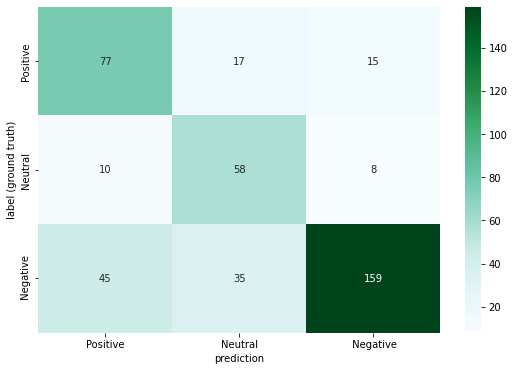

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(dataset.test_y.detach().cpu().numpy(), n_class)
class_names = ['Positive', 'Neutral', ' Negative']
print(arr)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

## INFERENCE

---



In [ ]:
def print_results(y):
  predict = [np.exp(c) for c in y]
  max = np.argmax(predict)
  print(f'Predicted: {classes[max].capitalize()}')
  print(f'Positive: {round(predict[0][0]*100, 4)}%')
  print(f'Neutral: {round(predict[0][1]*100, 4)}%')
  print(f'Negative: {round(predict[0][2]*100, 4)}%')

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [ ]:
# NEGATIVE TRUTH
inf_X = inference('/content/data/MyDrive/dl/ravdess/Actor_01/03-01-05-01-01-02-01.wav')
X = Norm(inf_X)
y = cnn.forward(X)
y = y.cpu().detach().numpy()
print_results(y)

Predicted: Negative
Positive: 10.478%
Neutral: 0.621%
Negative: 88.9009%


In [ ]:
# NEUTRAL TRUTH
inf_X = inference('/content/data/MyDrive/dl/ravdess/Actor_03/03-01-01-01-02-01-03.wav')
X = Norm(inf_X)
y = cnn.forward(X)
y = y.cpu().detach().numpy()
print_results(y)

Predicted: Neutral
Positive: 32.7862%
Neutral: 34.0334%
Negative: 33.1804%


In [ ]:
# POSITIVE TRUTH
inf_X = inference('/content/data/MyDrive/dl/ravdess/Actor_03/03-01-03-01-02-01-03.wav')
X = Norm(inf_X)
y = cnn.forward(X)
y = y.cpu().detach().numpy()
print_results(y)

Predicted: Positive
Positive: 40.8426%
Neutral: 27.3688%
Negative: 31.7885%
